<a href="https://colab.research.google.com/github/CelikAbdullah/deep-learning-notebooks/blob/main/Deep%20Reinforcement%20Learning/Actor-Critic/A2C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym
import time
from itertools import count
import torch.multiprocessing as mp

# Policy and Value Network

In A2C, we use a single neural network for both the policy and the value function. In the following, you can see the fully connected actor-critic model.

In [ ]:
class ACNetwork(nn.Module):
  def __init__(self,
               input_dim,
               output_dim,
               hidden_dims=(32,32),
               activation_fc=F.relu):

    super(ACNetwork, self).__init__()

    # set the activation function
    self.activation_fc = activation_fc

    # input layer
    self.input_layer = nn.Linear(input_dim, hidden_dims[0])

    # hidden layers
    self.hidden_layers = nn.ModuleList()
    for i in range(len(hidden_dims)-1):
      hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
      self.hidden_layers.append(hidden_layer)

    # value output
    self.value_output_layer = nn.Linear(hidden_dims[-1], 1)

    # policy output
    self.policy_output_layer = nn.Linear(hidden_dims[-1], output_dim)


  def _format(self, state):
    '''
    For formatting the input.
    '''
    x = state
    if not isinstance(x, torch.Tensor):
      x = torch.tensor(x, dtype=torch.float32)
      if len(x.size()) == 1:
        x = x.unsqueeze(0)

    return x

  def forward(self, state):
    '''
    Define the forward pass.
    '''
    x = self._format(state)
    x = self.activation_fc(self.input_layer(x))
    for hidden_layer in self.hidden_layers:
      x = self.activation_fc(hidden_layer(x))
    return self.policy_output_layer(x), self.value_output_layer(x)

  def full_pass(self, state):

    # perform the forward pass to obtain the logits (preferences over the actions)
    # logits are interpreted to be the unnormalized (or not yet normalized) predictions
    # (or outputs) of a model
    logits, value = self.forward(state)

    # create a probability distribution using the logits
    dist = torch.distributions.Categorical(logits=logits)

    # sample an action from the probability distribution
    action = dist.sample()

    # get the log probabilities of the selected action
    logpa = dist.log_prob(action).unsqueeze(-1)

    # compute the entropy of the policy
    # high entropy when action probabilities are similar to each other
    # low entropy when 1 action has a very high probability & all other actions have low probability
    # the entropy will be used in the loss function
    entropy = dist.entropy().unsqueeze(-1)

    # convert action to NumPy if necessary
    action = action.item() if len(action) == 1 else action.data.numpy()


    return action, logpa, entropy, value

  def select_action(self, state):
    '''
    Sample an action from the probability distribution.
    '''
    logits, _ = self.forward(state)
    dist = torch.distributions.Categorical(logits=logits)
    action = dist.sample()
    action = action.item() if len(action) == 1 else action.data.numpy()
    return action

  def select_greedy_action(self, state):
    '''
    Select a greedy action according to the policy.
    '''
    logits, _ = self.forward(state)
    return np.argmax(logits.detach().numpy())

  def evaluate_state(self, state):
    '''
    Get the value of the state.
    '''
    _, value = self.forward(state)
    return value

# Multiprocess environment

In A2C, we move the actor-workers from the agent down to the environment. Instead of having multiple actor-learners, we have multiple actors with a single learner. In the following, you can see the multi-process environment class which creates workers and pipes to communicate with the workers.

In [ ]:
class MultiprocessEnv(object):
  def __init__(self, env, seed, n_workers):

    # set the attributes
    self.env = env
    self.seed = seed
    self.n_workers = n_workers

    # create the pipes to communicate with the workers
    self.pipes = [mp.Pipe() for rank in range(self.n_workers)]

    # create the workers
    self.workers = [mp.Process(target=self.work, args=(rank, self.pipes[rank][1])) for rank in range(self.n_workers)]

    # start the workers
    [w.start() for w in self.workers]
    self.dones = {rank:False for rank in range(self.n_workers)}

  def reset(self, rank=None, **kwargs):
    if rank is not None:
      parent_end, _ = self.pipes[rank]
      self.send_msg(('reset', {}), rank)
      o = parent_end.recv()
      return o

    self.broadcast_msg(('reset', kwargs))
    return np.vstack([parent_end.recv() for parent_end, _ in self.pipes])

  def step(self, actions):
    '''
    Main step function. When called, it broadcasts the command
    and arguments to the workers.
    '''
    assert len(actions) == self.n_workers
    [self.send_msg(('step', {'action':actions[rank]}), rank) for rank in range(self.n_workers)]

    results = []
    # workers do their part and back the data
    # data is collected here
    for rank in range(self.n_workers):
      parent_end, _ = self.pipes[rank]
      o, r, d, i = parent_end.recv()

      # append and stack the results
      results.append((o,
                      np.array(r, dtype=np.float),
                      np.array(d, dtype=np.float),
                      i))

    return [np.vstack(block) for block in np.array(results).T]

  def close(self, **kwargs):
    self.broadcast_msg(('close', kwargs))
    [w.join() for w in self.workers]

  def _past_limit(self, **kwargs):
    self.broadcast_msg(('_past_limit', kwargs))
    return np.vstack([parent_end.recv() for parent_end, _ in self.pipes])

  def work(self, rank, worker_end):
    # build the environment for the worker
    env = self.env
    env.seed(self.seed + rank)

    # worker listens for commands
    while True:
      cmd, kwargs = worker_end.recv()

      # each command calls the respective env function and
      # sends the response back to the parent process
      if cmd == 'reset':
        worker_end.send(env.reset(**kwargs))

      elif cmd == 'step':
        worker_end.send(env.step(**kwargs))

      elif cmd == '_past_limit':
        worker_end.send(env._elapsed_steps >= env._max_episode_steps)

      else:
        # including close command
        env.close(**kwargs) ; del env ; worker_end.close()
        break

  def send_msg(self, msg, rank):
    parent_end, _ = self.pipes[rank]
    parent_end.send(msg)

  def broadcast_msg(self, msg):
    [parent_end.send(msg) for parent_end, _ in self.pipes]

# A2C agent

A2C stands for advantage actor-critic and is a synchronous version of A3C. Removing the asynchronous part of A3C yields a comparable algorithm without the need for implementing custom optimizers. A2C is an on-policy method that trains a stochastic policy.

In A2C, we have a single agent driving the interaction with the environment. The environment is a multi-process class that gathers samples from multiple environments at once.
Basically, we sample parallel environments to gather the mini-batches of data and use GAE for policy targets.

In [ ]:
class A2C():

  def __init__(self,
               model,
               model_max_grad_norm,
               optimizer,
               policy_loss_weight,
               value_loss_weight,
               entropy_loss_weight,
               max_n_steps,
               n_workers,
               tau,
               multiprocessEnv,
               env,
               seed,
               gamma,
               max_minutes,
               max_episodes,
               goal_mean_100_reward
               ):

    assert n_workers > 1

    # set the attributes
    self.model = model
    self.model_max_grad_norm = model_max_grad_norm
    self.optimizer = optimizer
    self.policy_loss_weight = policy_loss_weight
    self.value_loss_weight = value_loss_weight
    self.entropy_loss_weight = entropy_loss_weight
    self.max_n_steps = max_n_steps
    self.n_workers = n_workers
    self.tau = tau
    self.envs = multiprocessEnv
    self.env = env
    self.seed = seed
    self.gamma = gamma
    self.max_minutes = max_minutes
    self.max_episodes = max_episodes
    self.goal_mean_100_reward = goal_mean_100_reward

  def interact(self, states):
    # pass the state through the model
    actions, logpas, entropies, values = self.model.full_pass(states)

    # take the action in the environments
    next_states, rewards, is_terminals, _ = self.envs.step(actions)

    # append the log probs, entropies, rewards and values
    self.logpas.append(logpas)
    self.entropies.append(entropies)
    self.rewards.append(rewards)
    self.values.append(values)

    return next_states, is_terminals


  def optimize(self):

    # concatenate all log probs along dim=0 and reduce dimension via squeeze()
    logpas = torch.stack(self.logpas).squeeze()

    # concatenate all entropies along dim=0 and reduce dimension via squeeze()
    entropies = torch.stack(self.entropies).squeeze()

    # concatenate all values along dim=0 and reduce dimension via squeeze()
    values = torch.stack(self.values).squeeze()

    # compute the nr. of rewards
    T = len(self.rewards)

    # compute the discounts for each reward
    discounts = np.logspace(0, T, num=T, base=self.gamma, endpoint=False)

    # convert rewards to a NumPy array
    rewards = np.array(self.rewards).squeeze()

    # compute the sum of the discounted returns of each worker for all time steps
    returns = np.array([[np.sum(discounts[:T-t] * rewards[t:, w]) for t in range(T)]
                             for w in range(self.n_workers)])

    # convert values to NumPy
    np_values = values.data.numpy()

    # compute the tau discounts
    tau_discounts = np.logspace(0, T-1, num=T-1, base=self.gamma*self.tau, endpoint=False)

    # compute the advantages
    advs = rewards[:-1] + self.gamma * np_values[1:] - np_values[:-1]

    # compute the generalized advantage estimates
    gaes = np.array([[np.sum(tau_discounts[:T-1-t] * advs[t:, w]) for t in range(T-1)]
                             for w in range(self.n_workers)])

    # discount the gaes
    discounted_gaes = discounts[:-1] * gaes

    # via view() we return a new tensor with the same data but with a different shape
    values = values[:-1,...].view(-1).unsqueeze(1)
    logpas = logpas.view(-1).unsqueeze(1)
    entropies = entropies.view(-1).unsqueeze(1)

    # convert returns & discounted_gaes to a FloatTensor
    returns = torch.FloatTensor(returns.T[:-1]).contiguous().view(-1).unsqueeze(1)
    discounted_gaes = torch.FloatTensor(discounted_gaes.T).contiguous().view(-1).unsqueeze(1)


    # adjust T and check some assertions before we move on
    T -= 1
    T *= self.n_workers
    assert returns.size() == (T, 1)
    assert values.size() == (T, 1)
    assert logpas.size() == (T, 1)
    assert entropies.size() == (T, 1)

    # compute the value error
    value_error = returns.detach() - values

    # compute the value loss
    value_loss = value_error.pow(2).mul(0.5).mean()

    # compute the policy loss
    policy_loss = -(discounted_gaes.detach() * logpas).mean()

    # compute also entropy loss
    entropy_loss = -entropies.mean()

    # compute the final loss of our policy network
    # note that the value loss is part of it since the value
    # network is used as critic
    loss = self.policy_loss_weight * policy_loss + \
                self.value_loss_weight * value_loss + \
                self.entropy_loss_weight * entropy_loss

    # as usual, zero-out the gradients, backpropagate the gradients,
    # clip the gradient magnitude and finally update the weights
    self.optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(self.model.parameters(),
                                   self.model_max_grad_norm)
    self.optimizer.step()


  def train(self):

    # set the training start
    training_start = time.time()

    # some initialization
    states = self.envs.reset()
    n_steps_start = 0
    episode = 0
    self.logpas, self.entropies, self.rewards, self.values = [], [], [], []
    self.evaluation_scores = []

    for step in count(start=1):
      # interact with the environment
      states, is_terminals = self.interact(states)

      if is_terminals.sum() or step - n_steps_start == self.max_n_steps:
        # past limits
        past_limits_enforced = self.envs._past_limit()
        # determine if there is a failure
        is_failure = np.logical_and(is_terminals, np.logical_not(past_limits_enforced))

        # compute the next values
        next_values = self.model.evaluate_state(states).detach().numpy() * (1 - is_failure)

        # append next results
        self.rewards.append(next_values)
        self.values.append(torch.Tensor(next_values))

        # optimize the actor-critic model
        self.optimize()

        # reset the lists
        self.logpas, self.entropies, self.rewards, self.values = [], [], [], []

        # adjust the number of steps
        n_steps_start = step


      if is_terminals.sum():

        # evaluate the model
        evaluation_score = self.evaluate()

        # for all workers
        for i in range(self.n_workers):

          # if a terminal state is reached
          if is_terminals[i]:

            # reset
            states[i] = self.envs.reset(rank=i)

            # append evaluation score
            self.evaluation_scores.append(evaluation_score)

            # increment episode by 1
            episode +=1

            # compute mean evaluation score
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])

            # determine the elapsed wallclock since training start
            wallclock_elapsed = time.time() - training_start

        # some variables to determine whether max minutes/episodes or goal mean reward are reached
        reached_max_minutes = wallclock_elapsed >= max_minutes * 60
        reached_max_episodes = episode + self.n_workers >= max_episodes
        reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
        training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward

        if training_is_over:
          if reached_max_minutes: print('Max minutes are reached.')
          if reached_max_episodes: print('Max episodes are reached.')
          if reached_goal_mean_reward: print('Goal mean reward is reached.')
          break

    # evaluate the model
    final_eval_score = self.evaluate(episodes=100)
    print(f"Final_evaluation score: {final_eval_score}")

    self.env.close()
    del self.env
    self.envs.close()
    del self.envs

    return final_eval_score


  def evaluate(self, episodes=1, greedy=True):
    ''' Evaluate the model. '''

    # keep track of the rewards
    rewards = []

    # for each episode (default: 1) do the following
    for _ in range(episodes):
      # get the initial state
      state = self.env.reset()
      # set is_terminal flag to False
      is_terminal = False

      # append a 0 to rewards list
      rewards.append(0)

      # for each timestep of the current episode, do the following
      for _ in count():
        if greedy:
          # select a greedy action according to the policy.
          action = self.model.select_greedy_action(state)
        else:
          # sample an action from the distribution
          action = self.model.select_action(state)

        # take the action in the environment
        state, reward, is_terminal, _ = self.env.step(action)

        # save the reward
        rewards[-1] += reward

        # finish when terminal state is reached
        if is_terminal:
          break

    # return the mean of the rewards to the caller
    return np.mean(rewards)

Let's train the A2C agent:

In [ ]:
best_agent, best_eval_score = None, float('-inf')
SEEDS = (12, 34, 56, 78, 90)

# we let five A2C agents train, the one with the best evaluation score will be selected as the best one
# in each iteration, a different seed is used for creating the environment
for seed in SEEDS:
  # create an instance of the environment
  env = gym.make("CartPole-v1")
  env.seed(seed)

  # obtain the number of variables used in each state and the number of actions
  nS, nA = env.observation_space.shape[0], env.action_space.n

  # build the actor-critic network
  model = ACNetwork(nS, nA, hidden_dims=(256,128))
  model_max_grad_norm = 1
  optimizer= optim.RMSprop(model.parameters(), lr=0.001)

  # define the policy loss weight
  policy_loss_weight = 1.0

  # define the value loss weight
  value_loss_weight = 0.6

  # define the weight for the entropy loss
  entropy_loss_weight = 0.001

  # define max nr. of steps
  max_n_steps = 10

  # define number of workers
  n_workers = mp.cpu_count()

  #define the tau value
  tau = 0.95

  # define the our discount factor
  gamma = 0.99

  # define max minutes
  max_minutes = 10

  # define nr. of max episodes
  max_episodes = 10000

  # define mean reward value
  goal_mean_100_reward = 475

  # define multi process environment
  multiprocessEnv = MultiprocessEnv(env, seed, n_workers)

  # create the A2C agent
  agent = A2C(model,
               model_max_grad_norm,
               optimizer,
               policy_loss_weight,
               value_loss_weight,
               entropy_loss_weight,
               max_n_steps,
               n_workers,
               tau,
               multiprocessEnv,
               env,
               seed,
               gamma,
               max_minutes,
               max_episodes,
               goal_mean_100_reward
              )

  # let the A2C agent train
  final_evaluation_score = agent.train()

  if final_evaluation_score > best_eval_score:
    best_eval_score = final_evaluation_score
    best_agent = agent

<ipython-input-61-ba0e8377b84a>:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.array(r, dtype=np.float),
<ipython-input-61-ba0e8377b84a>:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return [np.vstack(block) for block in np.array(results).T]


Goal mean reward is reached.
Final_evaluation score: 500.0
Goal mean reward is reached.
Final_evaluation score: 500.0
Goal mean reward is reached.
Final_evaluation score: 500.0
Goal mean reward is reached.
Final_evaluation score: 500.0
Goal mean reward is reached.
Final_evaluation score: 500.0


# Save model

In [ ]:
torch.save(best_agent.model.state_dict(), "/content/drive/MyDrive/A2C/A2C_agent_final.pt")

# Visualization

In [ ]:
import os
import imageio
from PIL import Image as Im
import PIL.ImageDraw as ImageDraw
from IPython import display

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
env = gym.make("CartPole-v1")
model = ACNetwork(env.observation_space.shape[0], env.action_space.n, hidden_dims=(256,128))
model.load_state_dict(torch.load("/content/drive/MyDrive/A2C/A2C_agent_final.pt"))
model.eval()

ACNetwork(
  (input_layer): Linear(in_features=4, out_features=256, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (value_output_layer): Linear(in_features=128, out_features=1, bias=True)
  (policy_output_layer): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
def create_gif(env, episodes):
  # list to keep track of frames
  frames = []

  for episode in range(1, episodes + 1):
    # get the initial state
    state = env.reset()

    # for each timestep, do the following
    for t in range(500):

      # select an action from the probability distribution
      action = model.select_action(state)

      # get the frame & store it
      frame = env.render(mode='rgb_array')

      # prepare the frame
      im = Im.fromarray(frame)
      drawer = ImageDraw.Draw(im)
      if np.mean(im) < 128:
        text_color = (255,255,255)
      else:
        text_color = (0,0,0)
        drawer.text((im.size[0]/20,im.size[1]/18), f'Episode: {episode+1}', fill=text_color)
        drawer.text((im.size[0]/20,im.size[1]/8), f'Timestep: {t+1}', fill=text_color)

      # store the frame
      frames.append(im)

      # take the action in the environment
      state, _, is_terminal, _ = env.step(action)

      # if we land at a terminal state, break
      if is_terminal:
        break

    # close the environment
    env.close()

    # create the gif
    imageio.mimwrite(os.path.join('/content/drive/MyDrive/Gif/', 'A2C_agent.gif'), frames, fps=60)

In [ ]:
episodes = 5
env = gym.make('CartPole-v1')
create_gif(env, episodes)

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


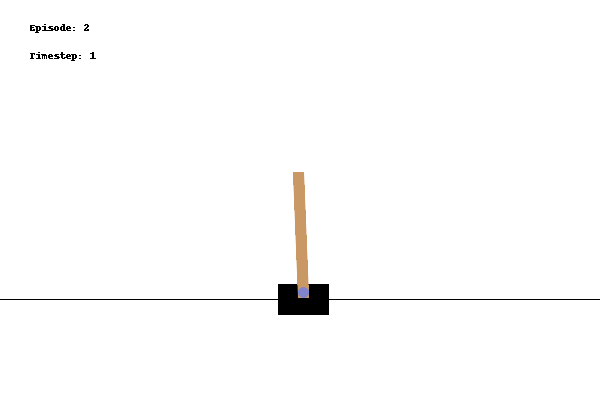

In [ ]:
from IPython import display
display.Image(open('/content/drive/MyDrive/Gif/A2C_agent.gif','rb').read())